# Ultrasound Image Segmentation with U-Net

This notebook is designed to guide you through the process of performing image segmentation on ultrasound images using a U-Net model. You will learn how to prepare the dataset, visualize images, define the U-Net architecture, and train the model. Some parts of the code are left as `TODO` for you to complete.


In [ ]:
name:   Zahra Fallah Mir Mousavi
stunumb: 401207192

SyntaxError: invalid syntax (<ipython-input-5-45427523eafc>, line 1)

## Dataset Preparation

First, we need to download and extract the dataset. This step is already done for you.


In [ ]:
!pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=1L9HvScE5csRhG9tyrjYmOb3ROmW6Qs1r'
output = 'downloaded_file.zip'

# Download the file
gdown.download(url, output, quiet=False)

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("dataset")


Downloading...
From (original): https://drive.google.com/uc?id=1L9HvScE5csRhG9tyrjYmOb3ROmW6Qs1r
From (redirected): https://drive.google.com/uc?id=1L9HvScE5csRhG9tyrjYmOb3ROmW6Qs1r&confirm=t&uuid=e6e1d30e-b035-43cd-9f2e-e1ef27a76dd1
To: /content/downloaded_file.zip
100%|██████████| 177M/177M [00:00<00:00, 185MB/s]


In [ ]:
# Identify and print all file types in the dataset directory
import os
dataset_dir = "/content/dataset"
file_types = set()

for root, _, files in os.walk(dataset_dir):
    for file in files:
        file_extension = os.path.splitext(file)[-1].lower()  # Get file extension
        file_types.add(file_extension)

print(f"Found file types: {file_types}")

deleted_files = []
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".db"):
            file_path = os.path.join(root, file)
            os.remove(file_path)  # Delete the file
            deleted_files.append(file_path)

# Print deleted .db files
print(f"Deleted .db files: {deleted_files}")

Found file types: {'.db', '.png'}
Deleted .db files: ['/content/dataset/training_set/training_set/Thumbs.db', '/content/dataset/test_set/test_set/Thumbs.db']


## Visualizing Annotations

Visualize the specified annotation to understand the data better.


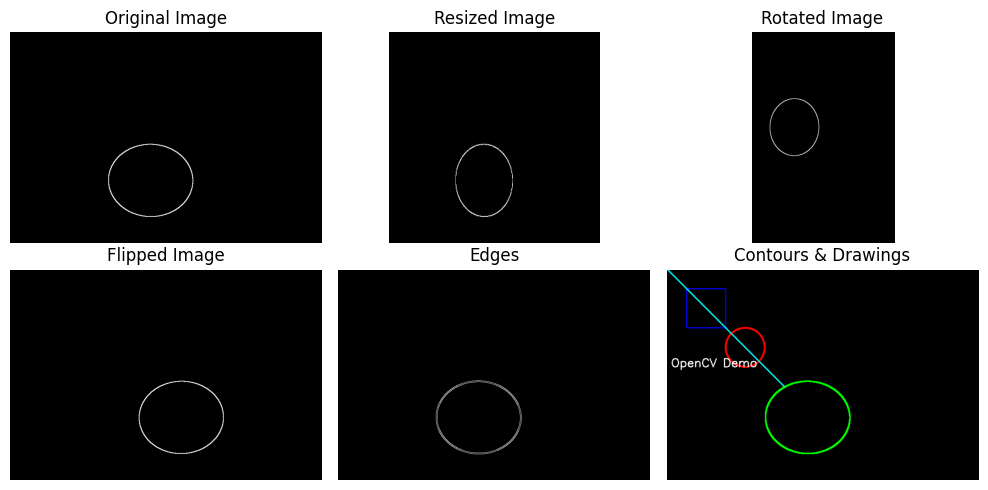

In [ ]:
import cv2
import matplotlib.pyplot as plt

annotation = "dataset/training_set/training_set/100_2HC_Annotation.png"
## TODO: check out cv2 methods like imread, findContours, drawContours, ...

# Load the image
image = cv2.imread(annotation)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Resize the image
resized_image = cv2.resize(image, (300, 300))

# Rotate the image by 90 degrees
rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

# Flip the image horizontally
flipped_image = cv2.flip(image, 1)

# Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred_image, 100, 200)

# Apply thresholding
_, thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)

# Draw a rectangle on the image
cv2.rectangle(image_with_contours, (50, 50), (150, 150), (255, 0, 0), 2)

# Draw a circle on the image
cv2.circle(image_with_contours, (200, 200), 50, (0, 0, 255), 3)

# Draw a line on the image
cv2.line(image_with_contours, (0, 0), (300, 300), (255, 255, 0), 2)

# Write text on the image
cv2.putText(image_with_contours, 'OpenCV Demo', (10, 250), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display resized image
plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Resized Image')
plt.axis('off')

# Display rotated image
plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.title('Rotated Image')
plt.axis('off')

# Display flipped image
plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(flipped_image, cv2.COLOR_BGR2RGB))
plt.title('Flipped Image')
plt.axis('off')

# Display image with edges
plt.subplot(2, 3, 5)
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.axis('off')

# Display image with contours and drawings
plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title('Contours & Drawings')
plt.axis('off')

plt.tight_layout()
plt.show()


## Image Preprocessing

We need to pad images to make them square for the U-Net model.


torch.Size([1, 812, 812])


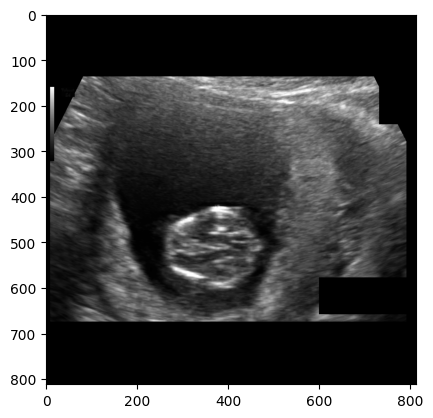

In [ ]:
import numpy as np
from PIL import Image
from torchvision.io import read_image
import torch
import matplotlib.pyplot as plt

def pad_image_to_square(img):
    ## TODO: we want the image size to be 812 by 812, add padding to images accordingly
    w, h, _ = img.shape
    # Calculate padding
    padding_h = max(812 - h, 0)
    padding_w = max(812 - w, 0)

    # Calculate padding on each side (added equally)
    padding_top = padding_h // 2
    padding_bottom = padding_h - padding_top
    padding_left = padding_w // 2
    padding_right = padding_w - padding_left

    # Apply padding: (left, right, top, bottom)
    padded_img = torch.nn.functional.pad(torch.from_numpy(img).permute(2, 0, 1), (padding_top, padding_bottom, padding_left, padding_right,0,0), mode='constant', value=0)
    return padded_img

# Pad the image to make it square
image = read_image("./dataset/training_set/training_set/100_2HC.png").permute(1,2,0).numpy()
padded_img = pad_image_to_square(image)
print(padded_img.shape)

tensor_image = padded_img.permute(1, 2, 0)
plt.imshow(tensor_image,cmap='gray')
plt.show()



## Custom Dataset
In this part, you'll work with a custom dataset class in PyTorch. The dataset contains input images and their corresponding target

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import os
import numpy as np
from torchvision.io import read_image


class CustomDataset(Dataset):
    def __init__(self, img_path, transform=None, target_transform=None):
        self.img_path = img_path
        self.transform = transform
        self.target_transform = target_transform

        # TODO: Load the list of images from the directory, excluding annotation files.
        self.images = []
        for i in os.listdir(img_path):
            if not i.endswith('_Annotation.png'):
              self.images.append(i)

    def __len__(self):
        # TODO: Return the number of images in the dataset.
        return len(self.images)

    def __getitem__(self, index):
        # Load both the image and its corresponding segmentation mask.

        img_filename = self.images[index]
        img_path = os.path.join(self.img_path, img_filename)

        # TODO: Load the image from disk and use padding method you implemented earlier
        img = read_image(img_path)
        img = img.permute(1,2,0)
        img = img.numpy(force=True)

        img = pad_image_to_square(img)


        # Load the corresponding annotation file (target image)
        target_filename = img_filename.split('.')[0] + '_Annotation.' + img_filename.split('.')[1]
        target_path = os.path.join(self.img_path, target_filename)

        if os.path.exists(target_path):
            # TODO: Load the target mask, process contours like we did before (countor sould be filled)
            # then convert it to a PyTorch tensor and do the paddings like original image
            target = read_image(target_path)
            target = target.permute(1,2,0)
            target_np = target.numpy(force=True)

            # Find contours
            contours, _ = cv2.findContours(target_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Fill contours
            target_filled = cv2.drawContours(target_np,  contours, -1, (255, 255, 255), thickness=cv2.FILLED)

            # Pad the mask to square shape like the original image
            target = pad_image_to_square(target_filled)

        else:
            print(f"Warning: Target not found for image {img_filename}")
            target = torch.tensor([])  # Return empty tensor if no target found

        # Apply transformations if provided
        if self.transform:
            # TODO: Apply transformations to the input image.
            img = transform(img)

        if self.target_transform:
            # TODO: Apply transformations to the target mask and threshold it.
            target = transform(target)

        return img.float(), target.float()

# Define the transformation to resize the images to 64x64 pixels
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resizing to fixed dimensions
])


target_transform = transforms.Compose([
    transforms.Resize((64, 64))  # Resizing target annotations
])



# TODO: Instantiate the dataset with appropriate paths and transformations
dataset = CustomDataset("./dataset/training_set/training_set", transform, target_transform)

# TODO: Instantiate a dataset for testing, without target transformations
test_dataset = CustomDataset("./dataset/test_set/test_set", transform, None)

# TODO: Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

# TODO: Create data loaders for the training, validation, and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader =  DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Plot 5 images.

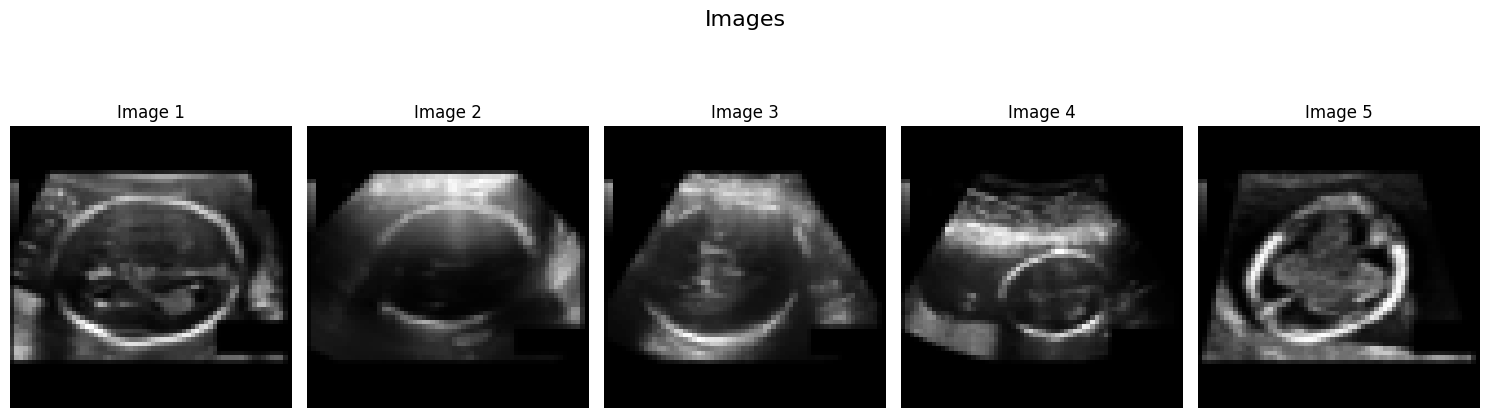

In [ ]:
import matplotlib.pyplot as plt

def plot_first_five_images(dataset):
    """Plots the first 5 images from the dataset."""
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle('Images', fontsize=16)

    for i in range(5):
        # Get the image and ignore the annotation for this plot
        image_tensor,_ = dataset[i]

        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Assuming normalization isn't needed for display
        # If normalization is necessary, uncomment the following line:
        # image_np = image_np / 255.0

        # Display the image
        axes[i].imshow(image_np, cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'dataset' is an instance of your custom dataset
plot_first_five_images(dataset)


Plot 5 annotations.

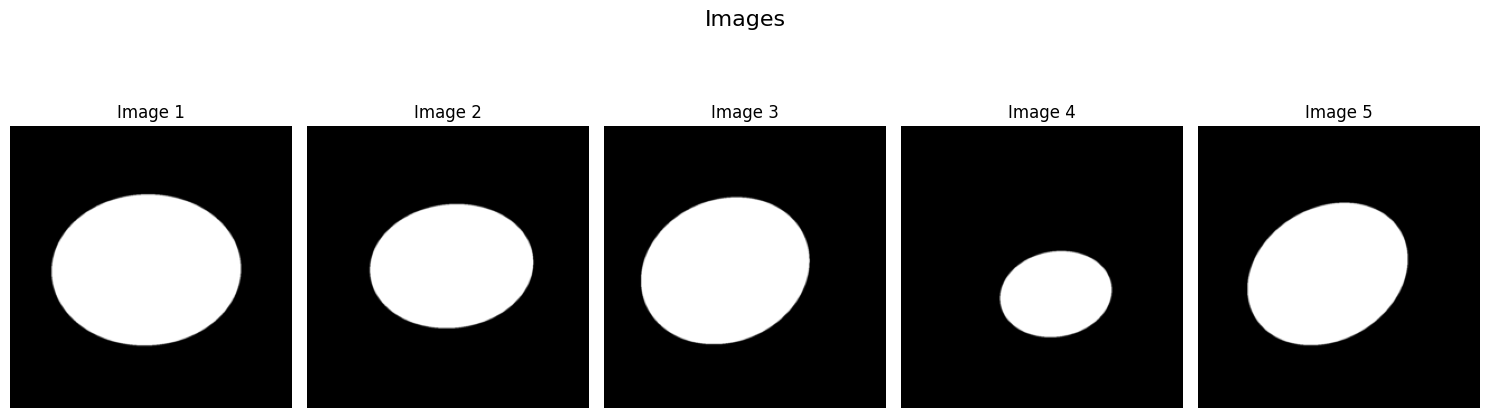

In [ ]:
import matplotlib.pyplot as plt

def plot_first_five_images(dataset):
    """Plots the first 5 images from the dataset."""
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle('Images', fontsize=16)

    for i in range(5):
        # Get the image and ignore the annotation for this plot
        _,target_tensor = dataset[i]

        image_np = target_tensor.permute(1, 2, 0).numpy()

        # Assuming normalization isn't needed for display
        # If normalization is necessary, uncomment the following line:
        # image_np = image_np / 255.0

        # Display the image
        axes[i].imshow(image_np, cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'dataset' is an instance of your custom dataset
plot_first_five_images(dataset)


## Model
Please implement UNet in this section.
Refer to [this](https://www.google.com/url?sa=i&url=https%3A%2F%2Flmb.informatik.uni-freiburg.de%2Fpeople%2Fronneber%2Fu-net%2F&psig=AOvVaw1nv1l6Mrp_e0SWoWYZ4g2n&ust=1729346930454000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCKDim76NmIkDFQAAAAAdAAAAABAJ)  image for the model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

def scale_tensor(image, new_height, new_width):
    scaled_image = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=True)
    return scaled_image

def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

def dual_conv(in_channel, out_channel):
    ## TODO define a Sequential nn
    ## dual_conv architecture:
    ## BatchNorm2d -> Conv2d -> BatchNorm2d -> activation (relu) -> Conv2d -> BatchNorm2d -> activate (relu)
    ## use kernel size 3
    conv = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )
    return conv

def out_layer(in_channel, out_channel):
    ## TODO: This the final layer of you UNet
    ## you should return this layer:
    ## Conv2d -> BatchNorm2d -> Sigmoid
    conv_layer = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=1),
        nn.BatchNorm2d(out_channel),
        nn.Sigmoid()
    )
    return conv_layer

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        ###################################
        ## TODO, define the architecture
        ## place dual_conv layers according to architecture
        ## HINT: you need to use 5 dual_conv layers here
        ## Also note that channel size of the input is 1 and it should be doubled at each layer
        # Left side (contracting path)

        # YOUR CODE HERE

        self.enc1 = dual_conv(1, 64)
        self.enc2 = dual_conv(64, 128)
        self.enc3 = dual_conv(128, 256)
        self.enc4 = dual_conv(256, 512)
        self.enc5 = dual_conv(512, 1024)

        ###################################
        self.conv_bn=nn.BatchNorm2d(1024) # hint, the size is 1024 at the bottleneck
        ###################################
        ## TODO, define the architecture
        ## place dual_conv layers according to architecture
        ## HINT: place 4 (transpose conv(kernel 2, stride 2), dual_conv) back to back
        # Right side  (expnsion path)

        # YOUR CODE HERE

        # Expanding path (decoder)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, output_padding=1)
        self.dec4 = dual_conv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, output_padding=1)
        self.dec3 = dual_conv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, output_padding=1)
        self.dec2 = dual_conv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, output_padding=1)
        self.dec1 = dual_conv(128, 64)

        ###################################

        #output layer
        ###################################
        ## TODO, final layer
        ## use out_layer method
        ## make sure the in_channel and out_channel are consistent with the contracting path

        # YOUR CODE HERE
        self.out_conv = out_layer(64, 1)
        ####################################

    def forward(self, image):
        ## TODO:
        ## apply defined layers
        ## remember to use self.maxpool after each downsample
        #forward pass for Left side
        enc1 = self.enc1(image)
        enc2 = self.enc2(self.maxpool(enc1))
        enc3 = self.enc3(self.maxpool(enc2))
        enc4 = self.enc4(self.maxpool(enc3))
        ## don't forget the conv_bn
        bottleneck = self.enc5(self.maxpool(enc4))

        ## TODO:
        ## figure out which previous tensor should be concated with the current tensor.
        ## use crop_tensor on the current tensor and the one from previous layers.
        ## b = crop_tensor(a, b) will setup b to get concated with a
        #forward pass for Right side

        up4 = self.upconv4(bottleneck)
        up4 = scale_tensor(up4, enc4.size(2), enc4.size(3))
        crop_enc4 = crop_tensor(enc4, up4)
        dec4 = self.dec4(torch.cat((crop_enc4, up4), dim=1))

        up3 = self.upconv3(dec4)
        up3 = scale_tensor(up3, enc3.size(2), enc3.size(3))
        crop_enc3 = crop_tensor(enc3, up3)
        dec3 = self.dec3(torch.cat((crop_enc3, up3), dim=1))

        up2 = self.upconv2(dec3)
        up2 = scale_tensor(up2, enc2.size(2), enc2.size(3))
        crop_enc2 = crop_tensor(enc2, up2)
        dec2 = self.dec2(torch.cat((crop_enc2, up2), dim=1))

        up1 = self.upconv1(dec2)
        up1 = scale_tensor(up1, enc1.size(2), enc1.size(3))
        crop_enc1 = crop_tensor(enc1, up1)
        dec1 = self.dec1(torch.cat((crop_enc1, up1), dim=1))

        image = self.out_conv(dec1)
        return image

In [ ]:
from torchsummary import summary
import torch

# Instantiate your model
model = Unet()

if torch.cuda.is_available():
    model = model.cuda()

# Use the summary function
# Input size should match your model's expected input dimensions (channels, height, width)
summary(model, input_size=(1, 572, 572))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 572, 572]               2
            Conv2d-2         [-1, 64, 572, 572]             640
       BatchNorm2d-3         [-1, 64, 572, 572]             128
              ReLU-4         [-1, 64, 572, 572]               0
            Conv2d-5         [-1, 64, 572, 572]          36,928
       BatchNorm2d-6         [-1, 64, 572, 572]             128
              ReLU-7         [-1, 64, 572, 572]               0
         MaxPool2d-8         [-1, 64, 286, 286]               0
       BatchNorm2d-9         [-1, 64, 286, 286]             128
           Conv2d-10        [-1, 128, 286, 286]          73,856
      BatchNorm2d-11        [-1, 128, 286, 286]             256
             ReLU-12        [-1, 128, 286, 286]               0
           Conv2d-13        [-1, 128, 286, 286]         147,584
      BatchNorm2d-14        [-1, 128, 2

## Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader



import gc
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


learning_rate = 1e-2
num_epochs = 15


# Define the U-Net architecture
model = Unet()
if torch.cuda.is_available():
  model.cuda()

# Define the loss function and optimizer

criterion = nn.BCELoss() ## use binary cross entropy. choose criterion carfully, we have already applied sigmoid on the model output!
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

v_loss , train_loss = [] , []
# Train the U-Net
for epoch in range(num_epochs):
  model.train()
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
      ## TODO
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      targets = targets.view_as(outputs)
      targets = (targets > 0.5).float()
      loss = criterion(outputs, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  model.eval()
  with torch.no_grad():
      val_loss = 0.0
      for val_inputs, val_targets in val_dataloader:
          val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

          val_targets = val_targets.view_as(val_targets)
          val_targets = (val_targets > 0.5).float()
          val_outputs = model(val_inputs)
          val_loss += criterion(val_outputs, val_targets)

  v_loss.append(val_loss.item())
  train_loss.append(loss.item())
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}  , Val Loss: {val_loss.item():.4f}")

# Save the trained model
# torch.save(model.state_dict(), 'path/to/trained/model')

Epoch [1/15], Train Loss: 0.3904  , Val Loss: 3.9678
Epoch [2/15], Train Loss: 0.3059  , Val Loss: 2.1730
Epoch [3/15], Train Loss: 0.2212  , Val Loss: 1.6977
Epoch [4/15], Train Loss: 0.1824  , Val Loss: 1.3883
Epoch [5/15], Train Loss: 0.1526  , Val Loss: 1.1996
Epoch [6/15], Train Loss: 0.1461  , Val Loss: 1.1432
Epoch [7/15], Train Loss: 0.1258  , Val Loss: 0.9637
Epoch [8/15], Train Loss: 0.1269  , Val Loss: 0.8407
Epoch [9/15], Train Loss: 0.1073  , Val Loss: 0.8746
Epoch [10/15], Train Loss: 0.0955  , Val Loss: 1.0536
Epoch [11/15], Train Loss: 0.0804  , Val Loss: 0.6573
Epoch [12/15], Train Loss: 0.0754  , Val Loss: 0.6610
Epoch [13/15], Train Loss: 0.0757  , Val Loss: 0.5492
Epoch [14/15], Train Loss: 0.0732  , Val Loss: 0.5367
Epoch [15/15], Train Loss: 0.0637  , Val Loss: 0.7931


## Evaluation
Use this code to evaluate your model. You should achieve more than 80%.

In [ ]:
def dice_coefficient(y_pred, y_true):
    smooth = 0.001
    y_pred = y_pred.view(-1)
    # print(type(y_pred), y_pred.shape)
    y_true = y_true.view(-1)
    intersection = torch.sum(y_pred * y_true)
    dice = (2.0 * intersection + smooth) / (torch.sum(y_pred) + torch.sum(y_true) + smooth)
    return dice

def dice_score(y_pred_batch, y_true_batch):
    dice_scores = torch.zeros(y_pred_batch.shape[0])
    for i in range(y_pred_batch.shape[0]):
        dice_scores[i] = dice_coefficient(y_pred_batch[i], y_true_batch[i])
    return dice_scores

with torch.no_grad():
  dice_com = torch.tensor([])
  model.to(device)
  model.eval()
  val_loss = 0
  for inputs, targets in val_dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)#
      targets = targets / 255.0


      outputs = model(inputs)
      outputs = torch.where(outputs > 0.5, torch.tensor([1.0]).to(device), torch.tensor([0.0]).to(device))
      dice = dice_score(outputs, targets)
      dice_com = torch.cat((dice_com, dice))

print("Dice Score of Validation Set")
dice_com.mean().item()

Dice Score of Validation Set


0.8434953093528748

0

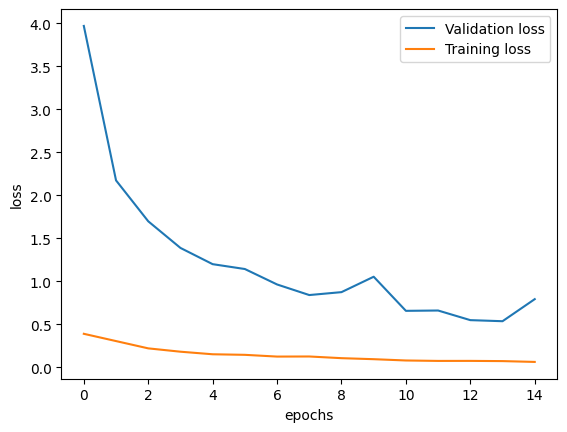

In [ ]:
import matplotlib.pyplot as plt
plt.plot(v_loss)
plt.plot(train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

5

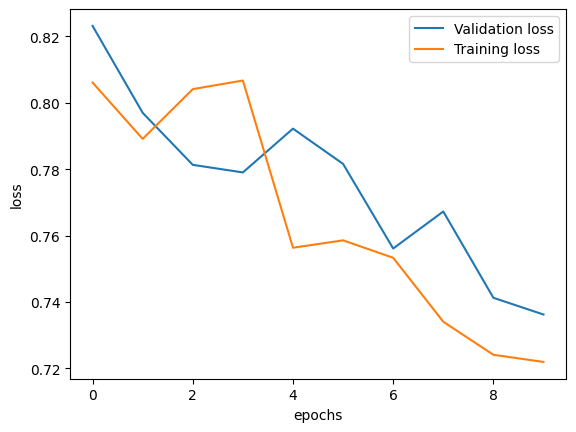

## Inference on the Test set
Iterate on the test data and calculate the predicted mask for each sample

In [ ]:
## TODO
import matplotlib.pyplot as plt

predicted_masks = []


with torch.no_grad():
  model.to(device)
  model.eval()
  for inputs, _ in test_dataloader:
      inputs = inputs.to(device)

      outputs = model(inputs)

      outputs = torch.where(outputs > 0.5, torch.tensor([1.0]).to(device), torch.tensor([0.0]).to(device))

      predicted_masks.extend(outputs.cpu().numpy())

predicted_masks = np.array(predicted_masks)


Plot 5 pairs of input and prediction to see your model in action

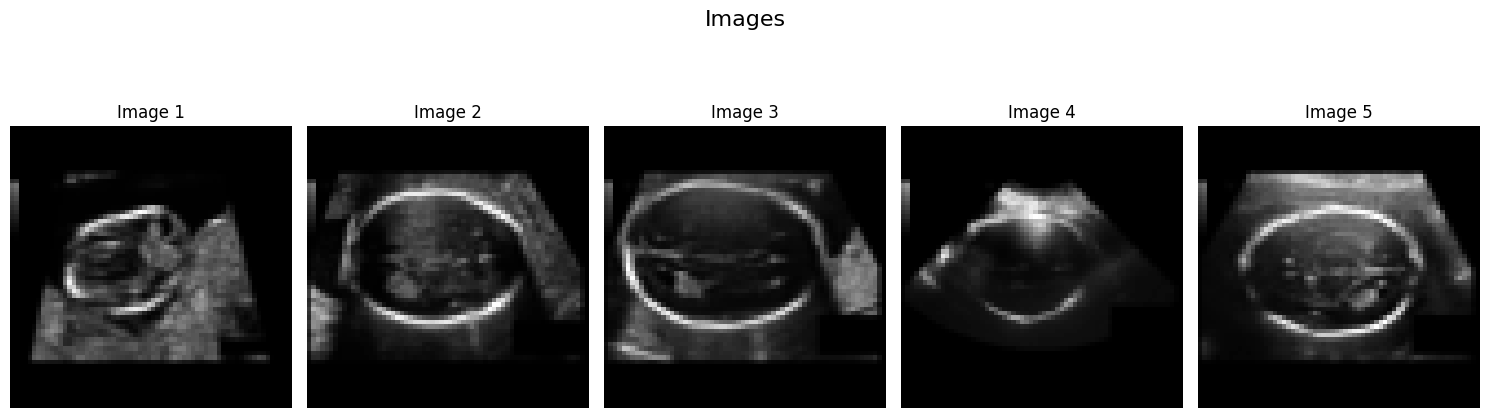

In [ ]:
plot_first_five_images(test_dataset)

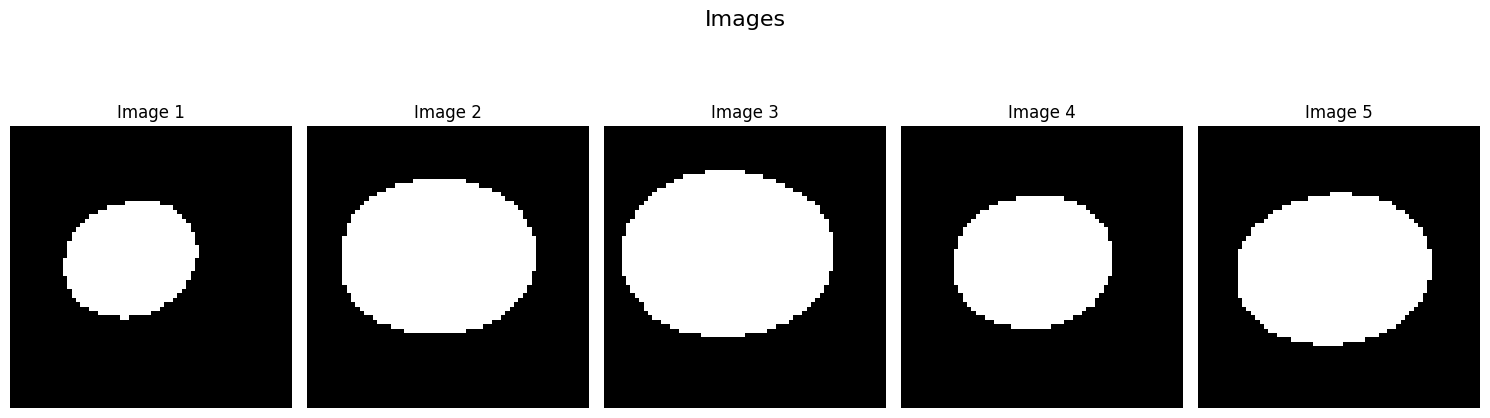

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Images', fontsize=16)

for i in range(5):
    # Get the image and ignore the annotation for this plot
    target_tensor = predicted_masks[i]


    # Assuming normalization isn't needed for display
    # If normalization is necessary, uncomment the following line:
    # image_np = image_np / 255.0

    # Display the image
    axes[i].imshow(target_tensor.reshape(64,64,1), cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()